In [47]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import cv2
from skimage import io, transform

## Data augmentation

### Images files
The 3D cube has been split in as many 2D tiff files as there are slices, each named 'slice_numberofslice.tif'

In [ ]:
cube = io.imread('C:/Users/Philippe/Desktop/Projet Recherche 3A/Data/Data.tif')

for i in range(cube.shape[0]):
    img = cube[i,:,:]
    filename = 'slice_'+str(i)+'.tif'
    io.imsave('C:/Users/Philippe/Desktop/Projet Recherche 3A/Data/Split/'+filename,img,plugin='tifffile')

### Dataset class

We use the dataset class from pytorch to represent the data.

The data are loaded in memory slice by slice in the _getitem_ method

A dataset object is created with two arguments idx_start and idx_end which let us use only slices between those two index.
This is because the first and last slices show some artifacts.

In [2]:
class Datas(Dataset):
    def __init__(self,root='C:/Users/Philippe/Desktop/Projet Recherche 3A/Data/Split/'\
                 ,transform=None,idx_start=0,idx_end=None):
        self.root=root
        self.transformation = transform
        self.idx_start=idx_start
        if idx_end==None:
            files = os.listdir(root)
            idx_end=len(files)
        self.idx_end=idx_end
        
    
    def __len__(self):
        return self.idx_end-self.idx_start
    
    def __getitem__(self, idx):
        idx2 = self.idx_start+idx
        filename='slice_'+str(idx2)+'.tif'
        image = io.imread(self.root+filename)  
        shape = image.shape
        image = image.reshape(shape[0],shape[1],1)
        if self.transformation!=None:
            image = self.transformation(image)
        return image

### Transformations
Here we define the set of transforms applied to a slice before it is loaded.
It is first binarized with an adapted threshold, then cropped to get only the center part,
then closed with morphological operation. After this we use data augmentation transforms such as random crop,
random vertical and horizontal flips.

In [3]:
class Crop(object):
    
    def __init__(self,corner,h,w):
        # corner est un tuple (x,y) qui représente le coin en bas à gauche, w et h (width et height sont des tuples)
        self.corner=corner
        self.w=w
        self.h=h
        
    def __call__(self,sample):
        x_corner=self.corner[0]
        y_corner=self.corner[1]
        return sample[self.corner[1]:self.corner[1]+self.h,self.corner[0]:self.corner[0]+self.w,:]

class Binarize(object):
    
    def __init__(self,threshold):
        self.threshold=threshold
    
    def __call__(self,sample):
        return (sample>self.threshold).astype(int)

class Closing(object):
    
    def __init__(self,kernel_size=(3,3)):
        self.kernel = np.ones(kernel_size,np.uint8)
    
    def __call__(self,sample):
        shape = sample.shape
        closed2D = cv2.morphologyEx(np.uint8(sample.reshape(shape[0],shape[1])),cv2.MORPH_CLOSE,self.kernel)
        return closed2D.reshape(shape)

We define the transformation pipeline with transformations from torchvision.transfroms and from the above transformations

In [4]:
# These values have been determined after trials on the dataset
thresh = 45153.32
(x,y) = (73,395)
w=860
h=225
crop_size=(150,250)

transform_pipeline = transforms.Compose([Binarize(thresh),Crop((x,y),h,w),Closing(),transforms.ToPILImage(),\
                                 transforms.RandomCrop(crop_size),transforms.RandomVerticalFlip(),\
                                 transforms.RandomHorizontalFlip(),transforms.ToTensor()])

### Examples

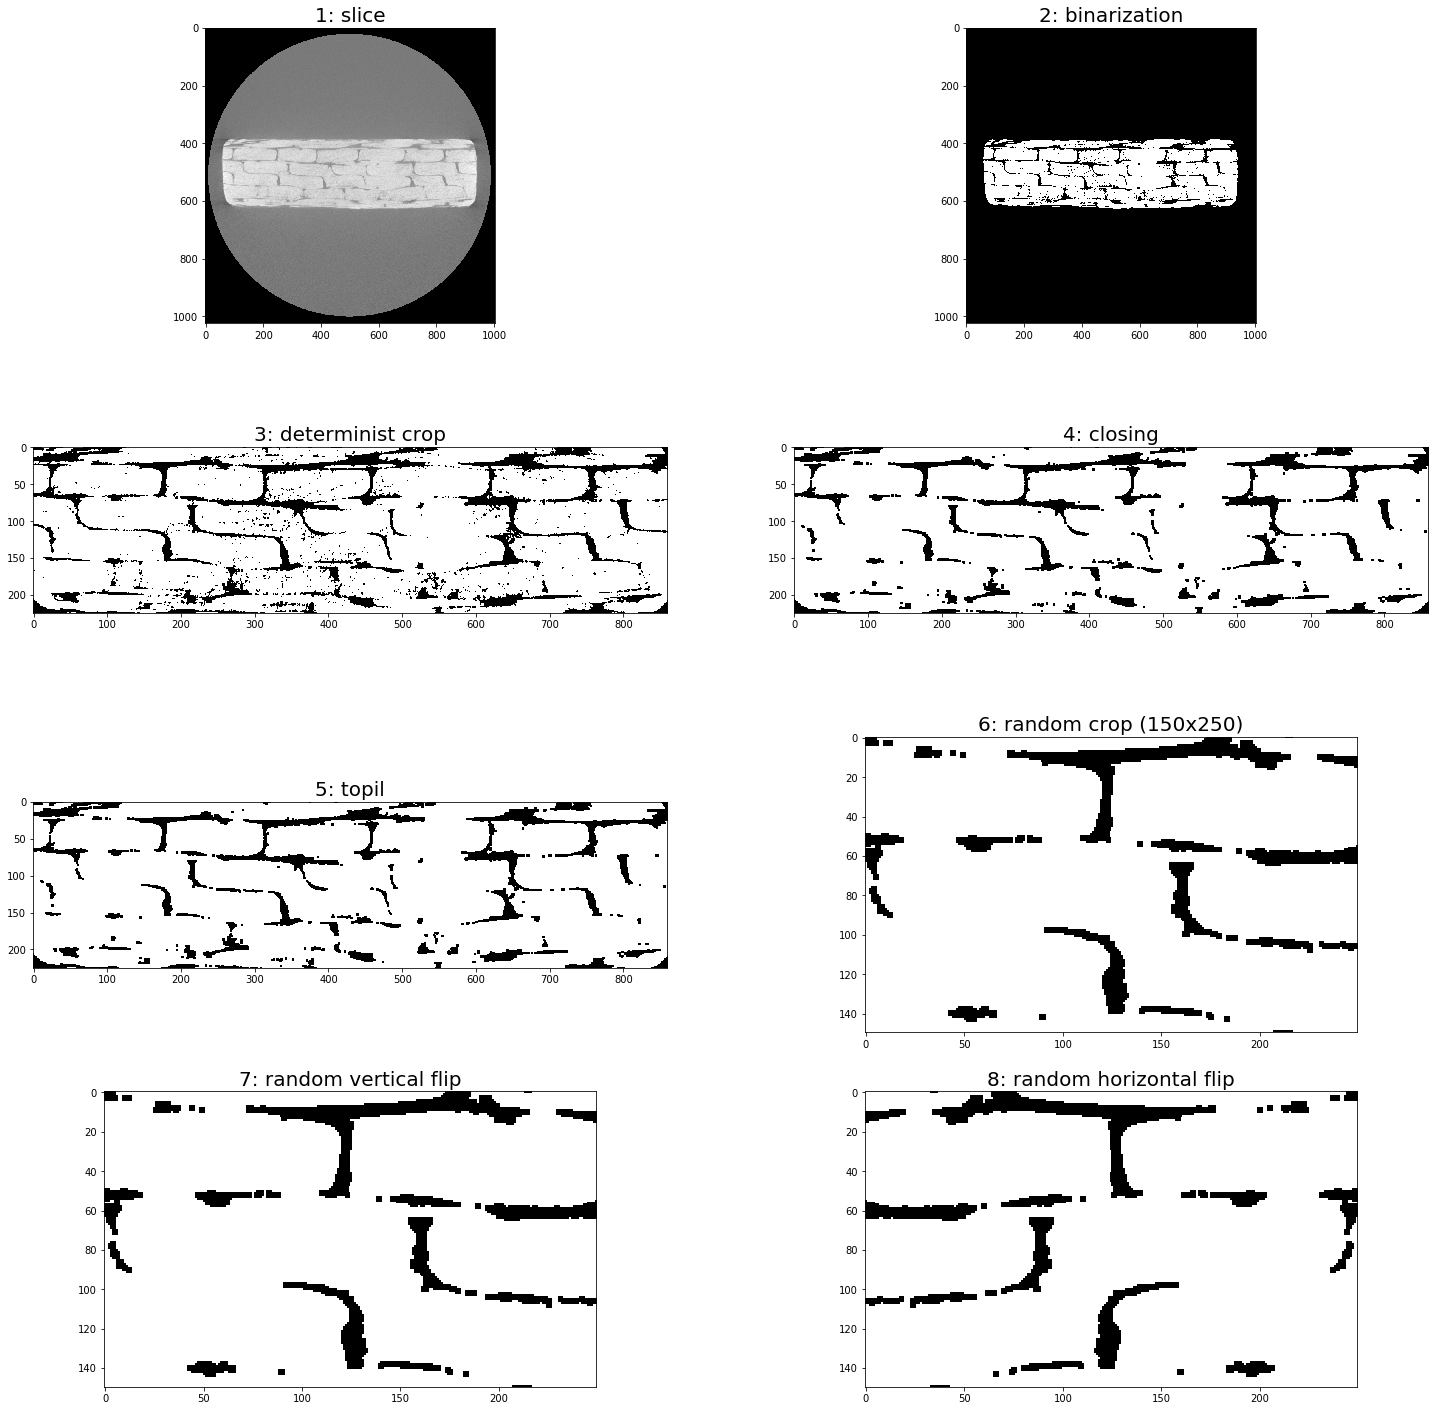

In [44]:
data = Datas()

img = data[200]

binar = Binarize(thresh)
crop = Crop((x,y),h,w)
close = Closing()
topil = transforms.ToPILImage()
rcrop = transforms.RandomCrop(crop_size)
rvflip = transforms.RandomVerticalFlip()
rhflip = transforms.RandomHorizontalFlip()

img2 = binar(img)
img3 = crop(img2)
img4 = close(img3)
img5 = topil(img4)
img6 = rcrop(img5)
img7 = rvflip(img6)
img8 = rhflip(img7)

def plot_numpy(ax,img,title):
    ax.imshow(img.reshape(img.shape[0],img.shape[1]),cmap='gray')
    ax.set_title(title,size=20)

def plot_pil(ax,img,title):
    ax.imshow(np.array(img),cmap='gray')
    ax.set_title(title,size=20)

f, axes = plt.subplots(4,2,figsize=(25,25))
plot_numpy(axes[0,0],img,'1: slice')
plot_numpy(axes[0,1],img2,'2: binarization')
plot_numpy(axes[1,0],img3,'3: determinist crop')
plot_numpy(axes[1,1],img4,'4: closing')
plot_pil(axes[2,0],img5,'5: topil')
plot_pil(axes[2,1],img6,'6: random crop (150x250)')
plot_pil(axes[3,0],img7,'7: random vertical flip')
plot_pil(axes[3,1],img8,'8: random horizontal flip')

## Net
### Percentile function
In the middle of the net, we need to get a sparse map regarding a predefined sparsity rate.
For this, we threshold the hidden map $D$ we want to make sparse with a sigmoid function: $D'=sigmoid(r(D-t))$
where t is the quantile over the whole batch of the map D, at the predefined sparsity rate level.

To get this quantile in a differentiable manner, we use the Robbins-Monro algorithm which is recursive. If $\theta_n$ is the estimator of the $\alpha$ level quantile, and $X_n$ are the variables over which we want to get the quantile (the intensity of every pixel of a 2D image in our case), then do

$\theta_{n+1}=\theta_n-\frac{2}{n+1}*(1_{(X_{n+1}\le\theta_n)}-\alpha)$

The indicator function is replaced here by a sigmoid and the quantiles are averaged over the batch dimension


In [45]:
def percentile(tens,alpha):
    n = tens.size(2)*tens.size(3)
    res = 2*(tens.view(-1,n)[:,0]<=1).to(torch.float32)-alpha
    perm=torch.randperm(n)
    for k in range(1,n):
        gamma_k=2/(k+1)
        res=res-gamma_k*(torch.sigmoid(5*(res-tens.view(-1,n)[:,perm[k]]))-alpha)
    return torch.mean(res)

In [54]:
tens = torch.randn(10,1,150,250)
n=10*150*250
t1 = percentile(tens,0.75)
t2 = percentile(tens,0.98)
rate_1 = (tens<=t1).to(torch.float32).sum()/n
rate_2 = (tens<=t2).to(torch.float32).sum()/n
print('number of pixels <t1: {}'.format(rate_1))
print('number of pixels <t2: {}'.format(rate_2))

number of pixels <t1: 0.7630266547203064
number of pixels <t2: 0.9739013314247131


### net

The architecture is the one from the paper https://arxiv.org/pdf/1704.00406.pdf

In the description below, the parts 4 and 8 are omitted because the background in our images is uniform
![](capture.png)

In [ ]:
class Sparse_AutoEncoder(nn.Module):
    
    def __init__(self,sparse_rate,r):
        super(Sparse_AutoEncoder, self).__init__()
        self.sparse_rate=sparse_rate
        self.r=r
                                                                      #1*150*250
        # --- Part 1 ---
        self.conv11=nn.Conv2d(1,60,(5,7),padding=(2,3))               #60*150*250
        self.conv12=nn.Conv2d(60,80,(5,7),padding=(2,3))              #80*150*250
        self.pool11=nn.AvgPool2d(kernel_size=2)                       #80*75*125
        self.conv13=nn.Conv2d(80,100,(5,5),padding=(2,3))             #100*75*125
        self.conv14=nn.Conv2d(100,120,(5,7),padding=(2,3))            #120*75*125
        self.pool12=nn.AvgPool2d(kernel_size=2,padding=(1,0))         #120*38*63
        self.conv15=nn.Conv2d(120,140,(3,5),padding=(1,2))            #140*38*63
        self.conv16=nn.Conv2d(140,160,(3,5),padding=(1,2))            #160*38*63

        # --- Part 2 --- fibers' centers detection
        self.conv21=nn.Conv2d(160,80,1)                               #80*38*63
        self.conv22=nn.Conv2d(80,1,1)                                 #1*38*63
        self.batchNorm=nn.BatchNorm2d(1)                              #1*38*63
        
        # --- Part 3 --- fibers' features
        self.conv31=nn.Conv2d(160,130,(3,5),padding=(1,2))            #130*38*63
        self.conv32=nn.Conv2d(130,100,(3,5),padding=(1,2))            #100*38*63
        
        # --- Part 7 --- deconvolution
        self.deconv41=nn.ConvTranspose2d(100,160,(3,5),padding=(1,2))     #120*38*63
        self.deconv42=nn.ConvTranspose2d(160,140,(3,5),padding=(1,2))     #140*38*63
        self.deconv43=nn.ConvTranspose2d(140,140,(3,5),padding=(1,2),stride=2)#140*75*125
        self.deconv44=nn.ConvTranspose2d(140,120,(3,5),padding=(1,2)) #120*75*125
        self.deconv45=nn.ConvTranspose2d(120,100,(3,5),padding=(1,2)) #100*75*125
        self.deconv46=nn.ConvTranspose2d(100,100,(3,5),padding=(1,2),stride=2,output_padding=1) #100*150*250
        self.deconv47=nn.ConvTranspose2d(100,80,(5,7),padding=(2,3))  #80*150*250
        self.deconv48=nn.ConvTranspose2d(80,60,(5,7),padding=(2,3))   #60*150*250
        
        # --- Output ---
        self.output=nn.ConvTranspose2d(60,1,1)                        #1*150*250
        
       
    def forward(self,x):
            
        # --- Part 1 ---
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool11(x)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        x = self.pool12(x)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
            
        # --- Part 2&5 ---
        x2 = F.relu(self.conv21(x))
        x2 = self.batchNorm(self.conv22(x2))
        #x2 = F.relu(self.conv22(x2))
        t = percentile(x2,1-self.sparse_rate)
        x2 = torch.sigmoid(self.r*(x2-t))   # r=20 is used in the paper
        
        # --- Part 3 ---
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
            
        # --- Part 6 Dotwise Product ---
        x = x2.expand(-1,100,-1,-1)*x
            
        # --- Part 7 ---
        x = F.relu(self.deconv41(x))
        x = F.relu(self.deconv42(x))
        x = F.relu(self.deconv43(x))
        x = F.relu(self.deconv44(x))
        x = F.relu(self.deconv45(x))
        x = F.relu(self.deconv46(x))
        x = F.relu(self.deconv47(x))
        x = F.relu(self.deconv48(x))
            
        x = torch.sigmoid(self.output(x))
            
        return {'detection':x2,'reconstruction':x, 'percentile':t}

## Training

In the training phase, we keep track of the quantiles by a moving average updated at each iteration:
$mav_{n+1}=(1-\alpha)mav_{n}+\alpha{t_n}$ where $t_n$ is the quantile calculated at iteration

In [ ]:
batch_size=16
num_epochs=1
sparsity = 0.01  #the desired sparsity rate for the map in part 5
alpha=0.1 
r=8

dataset = Datas(transform=transform_pipeline,idx_start=100,idx_end=900)
trainloader = DataLoader(dataset,shuffle=True,batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Sparse_AutoEncoder(sparsity,r)
net.to(device)

mse = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(net.parameters())
running_percentile = 1

for epoch in range(num_epochs):
    print('Epoch n°{}\n'.format(epoch))
    running_percentile = 1
    for i, data in enumerate(trainloader, 0):
        
        optimizer.zero_grad()
        
        data = data.to(device)
        outputs = net(data)
        detection = outputs['detection']
        reconstruction = outputs['reconstruction']
        running_percentile = (1-alpha)*running_percentile + alpha*outputs['percentile']
        
        loss = mse(reconstruction,data)
        
        loss.backward()
        optimizer.step()
        
        num_examples=0
        if i*batch_size<len(dataset):
            num_examples=i*batch_size
        else:
            num_examples=len(dataset)
        
        
        print('iteration {}   {}/{} examples processed'.format(i,num_examples,len(dataset)))
        print('\tloss: {}'.format(loss.item()))
        print('\tpercentile:')
        print('\t\trunning  {}'.format(running_percentile))
        print('\t\tbatch {}'.format(outputs['percentile']))
        print('\tsparsity rate {}'.format(detection.sum()/np.array(detection.size()).prod()))